In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


#Analysing the Dataset

In [ ]:
dataset_file = "Software_Failure_Dataset.xlsx"
df = pd.read_excel(dataset_file)

In [ ]:
df

,t,Yt
0,0,5.7683
1,1,9.5743
2,2,9.1050
3,3,7.9655
4,4,8.6482
...,...,...
96,96,12.7831
97,97,13.1585
98,98,12.7530
99,99,10.3533


In [ ]:
df.describe()

,t,Yt
count,101.000000,101.000000
mean,50.000000,10.249853
std,29.300171,2.140648
min,0.000000,4.700500
25%,25.000000,8.779400
50%,50.000000,10.178600
75%,75.000000,12.024600
max,100.000000,14.896900


In [ ]:
df.index = df['t']
df = df.drop(['t'], axis=1)
df.head()

,Yt
t,
0,5.7683
1,9.5743
2,9.1050
3,7.9655
4,8.6482


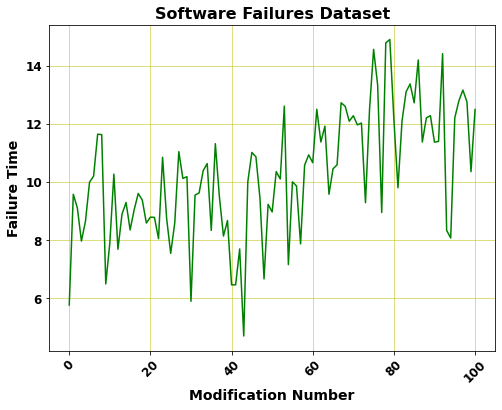

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df, color='g')
plt.title('Software Failures Dataset', weight='bold', fontsize=16)
plt.xlabel('Modification Number', weight='bold', fontsize=14)
plt.ylabel('Failure Time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


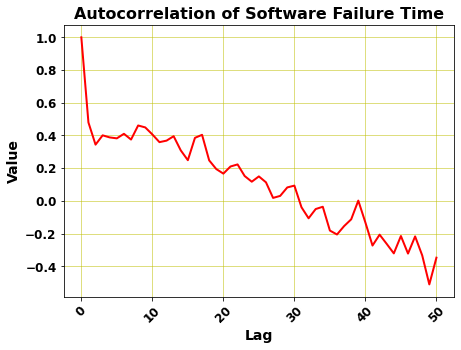

In [ ]:
from statsmodels.tsa import stattools

acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(df,
                                                             unbiased=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of Software Failure Time', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

In [ ]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['t'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['t'], drop=True, inplace=True)
    return df_copy

In [ ]:
list_of_attributes = ['Yt']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
df_new = create_regressor_attributes(df, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,Yt,Yt_(t-1),Yt_(t-2),Yt_(t-3),Yt_(t-4),Yt_(t-5),Yt_(t-6),Yt_(t-7),Yt_(t-8),Yt_(t-9),Yt_(t-10),Yt_(t-11),Yt_(t-12),Yt_(t-13),Yt_(t-14),Yt_(t-15)
t,,,,,,,,,,,,,,,,
15,8.3499,9.2933,8.8905,7.6839,10.2679,7.9010,6.4922,11.6275,11.6399,10.1962,9.9887,8.6482,7.9655,9.1050,9.5743,5.7683
16,9.0431,8.3499,9.2933,8.8905,7.6839,10.2679,7.9010,6.4922,11.6275,11.6399,10.1962,9.9887,8.6482,7.9655,9.1050,9.5743
17,9.6027,9.0431,8.3499,9.2933,8.8905,7.6839,10.2679,7.9010,6.4922,11.6275,11.6399,10.1962,9.9887,8.6482,7.9655,9.1050
18,9.3736,9.6027,9.0431,8.3499,9.2933,8.8905,7.6839,10.2679,7.9010,6.4922,11.6275,11.6399,10.1962,9.9887,8.6482,7.9655
19,8.5869,9.3736,9.6027,9.0431,8.3499,9.2933,8.8905,7.6839,10.2679,7.9010,6.4922,11.6275,11.6399,10.1962,9.9887,8.6482


In [ ]:
df_new.shape

(86, 16)

#Train, Validation and Test Sets

In [ ]:
test_set_size = 0.2
valid_set_size= 0.1

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (61, 15) (61,)
Shape of validation inputs, validation target: (7, 15) (7,)
Shape of test inputs, test target: (18, 15) (18,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#Score Printing and Graph Plotting Functions 

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, median_absolute_error

model_scores = {
    'ANN':{},
    'RNN':{},
    'GRU':{},
    'LSTM':{}
}

def print_scores(y_test_rescaled, y_pred_rescaled, model_name):
  MAE = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
  MSE = mean_squared_error(y_test_rescaled, y_pred_rescaled)
  MedAE = median_absolute_error(y_test_rescaled, y_pred_rescaled)
  MaxErr = max_error(y_test_rescaled, y_pred_rescaled)

  model_scores[model_name]['Mean Abs Err'] = MAE
  model_scores[model_name]['Mean Sq Err'] = MSE
  model_scores[model_name]['Median Abs Err'] = MedAE
  model_scores[model_name]['Max Err'] = MaxErr

  print('Mean Abs Err for the test set:', round(MAE,4))
  print('Mean Sq Err for the test set:', round(MSE,4))
  print('Median Abs Err for the test set:', round(MedAE,4))
  print('Max Err for the test set:', round(MaxErr,4))

def make_prediction_plot(y_test, y_pred):
  y_actual = pd.DataFrame(y_test, columns=['Actual Failure Time'])
  y_hat = pd.DataFrame(y_pred, columns=['Predicted Failure Time'])
  plt.figure(figsize=(11, 6))
  plt.plot(y_actual, linestyle='solid', color='r')
  plt.plot(y_hat, linestyle='dashed', color='b')

  plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
  plt.title('Software Reliability Prediction', weight='bold', fontsize=16)
  plt.ylabel('Failure Time', weight='bold', fontsize=14)
  plt.xlabel('Modification No.', weight='bold', fontsize=14)
  plt.xticks(weight='bold', fontsize=12, rotation=45)
  plt.yticks(weight='bold', fontsize=12)
  plt.grid(color = 'y', linewidth='0.5')
  plt.show()

#Import All Models

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

#ANN

In [ ]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(64, activation='linear')(input_layer)
dense2 = Dense(32, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


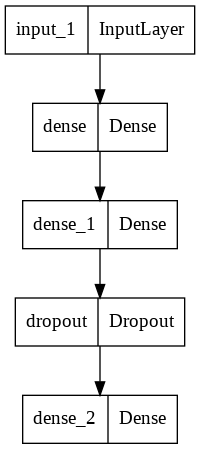

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=100, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 0.2194 - val_loss: 0.1812
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1928 - val_loss: 0.1488
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0854 - val_loss: 0.1268
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1068 - val_loss: 0.1180
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 0.1054
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0717 - val_loss: 0.1016
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0968
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0545 - val_loss: 0.0991
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0626 - val_loss: 0.1064
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.1143
Epoch 11

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

In [ ]:
print_scores(y_test_rescaled, y_pred_rescaled, 'ANN')

Mean Abs Err for the test set: 1.6247
Mean Sq Err for the test set: 3.6756
Median Abs Err for the test set: 1.3449
Max Err for the test set: 3.4827


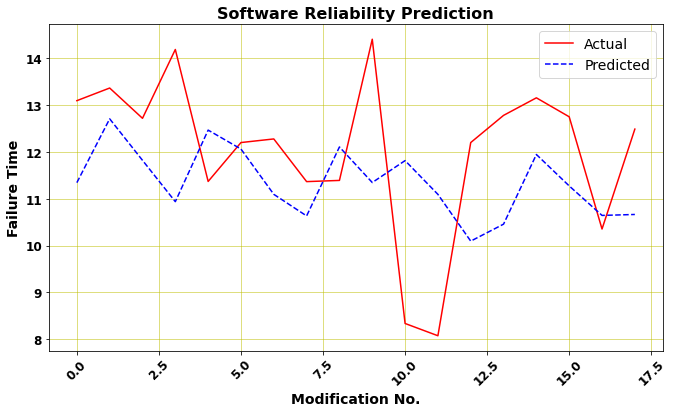

In [ ]:
make_prediction_plot(y_test_rescaled, y_pred_rescaled)

#LSTM

In [ ]:
def Reshape(x, model_name):
  if model_name=="LSTM":
    return x.reshape((x.shape[0], 1, x.shape[1]))
  return x

In [ ]:
model_name = "LSTM"
X_train_scaled = Reshape(X_train_scaled, model_name)
X_valid_scaled = Reshape(X_valid_scaled, model_name)
X_test_scaled = Reshape(X_test_scaled, model_name)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(1,15)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20480     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,593
Trainable params: 22,593
Non-trainable params: 0
_________________________________________________________________


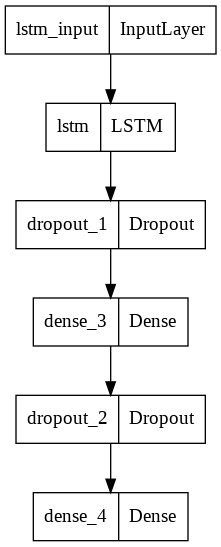

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=100, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/100
13/13 [==============================] - 2s 44ms/step - loss: 0.2259 - val_loss: 0.1690
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0374 - val_loss: 0.1543
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0439 - val_loss: 0.1446
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0347 - val_loss: 0.1448
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0364 - val_loss: 0.1432
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.1447
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.1452
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0365 - val_loss: 0.1471
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0315 - val_loss: 0.1463
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.1471
Epoch 11

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

In [ ]:
print_scores(y_test_rescaled, y_pred_rescaled, 'LSTM')

Mean Abs Err for the test set: 1.5639
Mean Sq Err for the test set: 3.4735
Median Abs Err for the test set: 1.4992
Max Err for the test set: 3.4095


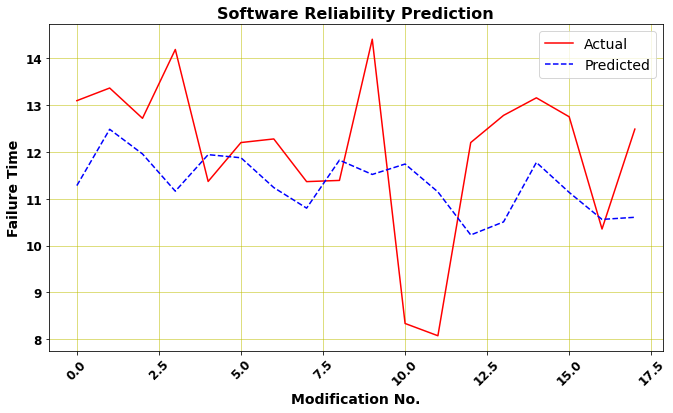

In [ ]:
make_prediction_plot(y_test_rescaled, y_pred_rescaled)

#GRU

In [ ]:
model = Sequential()
model.add(GRU(64, input_shape=(1,15)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15552     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


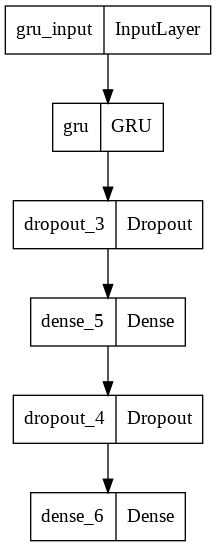

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=100, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/100
13/13 [==============================] - 2s 40ms/step - loss: 0.0889 - val_loss: 0.1791
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.1769
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.1628
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0466 - val_loss: 0.1608
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0405 - val_loss: 0.1621
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0360 - val_loss: 0.1638
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0484 - val_loss: 0.1644
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0279 - val_loss: 0.1631
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.1619
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0450 - val_loss: 0.1584
Epoch 11

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

In [ ]:
print_scores(y_test_rescaled, y_pred_rescaled, 'GRU')

Mean Abs Err for the test set: 1.6587
Mean Sq Err for the test set: 3.731
Median Abs Err for the test set: 1.5486
Max Err for the test set: 3.5465


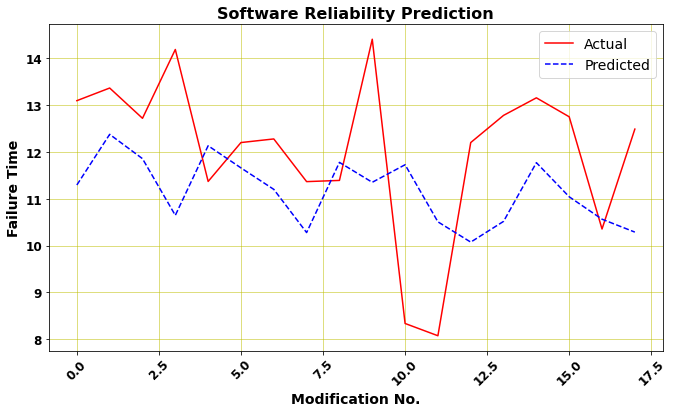

In [ ]:
make_prediction_plot(y_test_rescaled, y_pred_rescaled)

#RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1,15)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                5120      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,233
Trainable params: 7,233
Non-trainable params: 0
_________________________________________________________________


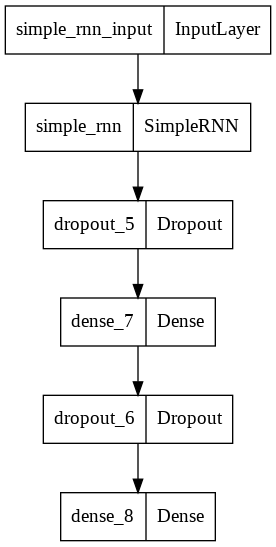

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=100, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 0.2479 - val_loss: 0.2020
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1601 - val_loss: 0.1816
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1355 - val_loss: 0.1625
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1308 - val_loss: 0.1628
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1178 - val_loss: 0.1645
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1057 - val_loss: 0.1742
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1258 - val_loss: 0.1769
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0980 - val_loss: 0.1690
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0994 - val_loss: 0.1859
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0891 - val_loss: 0.1683
Epoch 11

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

In [ ]:
print_scores(y_test_rescaled, y_pred_rescaled, 'RNN')

Mean Abs Err for the test set: 1.6821
Mean Sq Err for the test set: 3.7328
Median Abs Err for the test set: 1.6267
Max Err for the test set: 3.4486


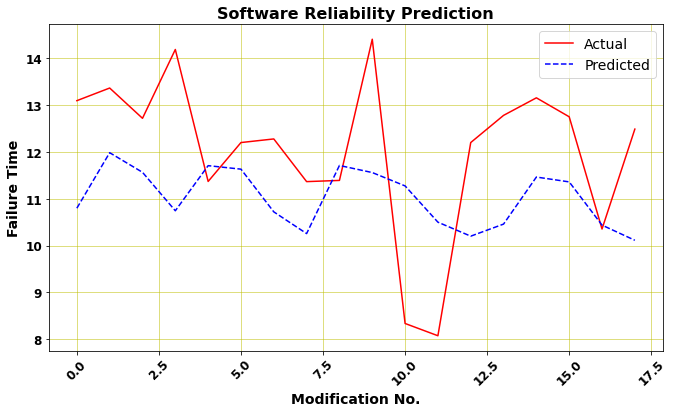

In [ ]:
make_prediction_plot(y_test_rescaled, y_pred_rescaled)

#Comparison

In [ ]:
from matplotlib.pyplot import figure

def print_comparison_graph(algos_name, error_names, error_val):
  figure(figsize=(20, 10), dpi=240)
  plt.rcParams.update({'font.size': 14})

  X = algos_name
  E = error_names
  E0 = error_val[:,0]
  E1 = error_val[:,1]
  E2 = error_val[:,2]
  E3 = error_val[:,3]
    
  X_axis = np.arange(len(X))
    
  plt.bar(X_axis - 0.3, E0, 0.2, label = E[0])
  plt.bar(X_axis - 0.1, E1, 0.2, label = E[1])
  plt.bar(X_axis + 0.1, E2, 0.2, label = E[2])
  plt.bar(X_axis + 0.3, E3, 0.2, label = E[3])
    
  plt.xticks(X_axis, X)
  plt.xlabel("ML/DL Algos")
  plt.ylabel("Error value")
  plt.title("Prediction Errors")
  plt.legend()
  plt.show()

In [ ]:
algos_name = list(model_scores.keys())
error_names = list(model_scores['ANN'].keys())

error_val = []
for algo in algos_name:
  error_val.append(list(model_scores[algo].values()))

error_val = np.array(error_val)
print(error_val)

[[1.62469358 3.67561845 1.3449216  3.4826771 ]
 [1.68207574 3.73280427 1.62665442 3.44857368]
 [1.65873032 3.73104299 1.54861118 3.5464817 ]
 [1.56387522 3.47346358 1.49918367 3.40953695]]


In [ ]:
scores_df = pd.DataFrame(model_scores.values())
scores_df.index = model_scores.keys()
scores_df

,Mean Abs Err,Mean Sq Err,Median Abs Err,Max Err
ANN,1.624694,3.675618,1.344922,3.482677
RNN,1.682076,3.732804,1.626654,3.448574
GRU,1.658730,3.731043,1.548611,3.546482
LSTM,1.563875,3.473464,1.499184,3.409537


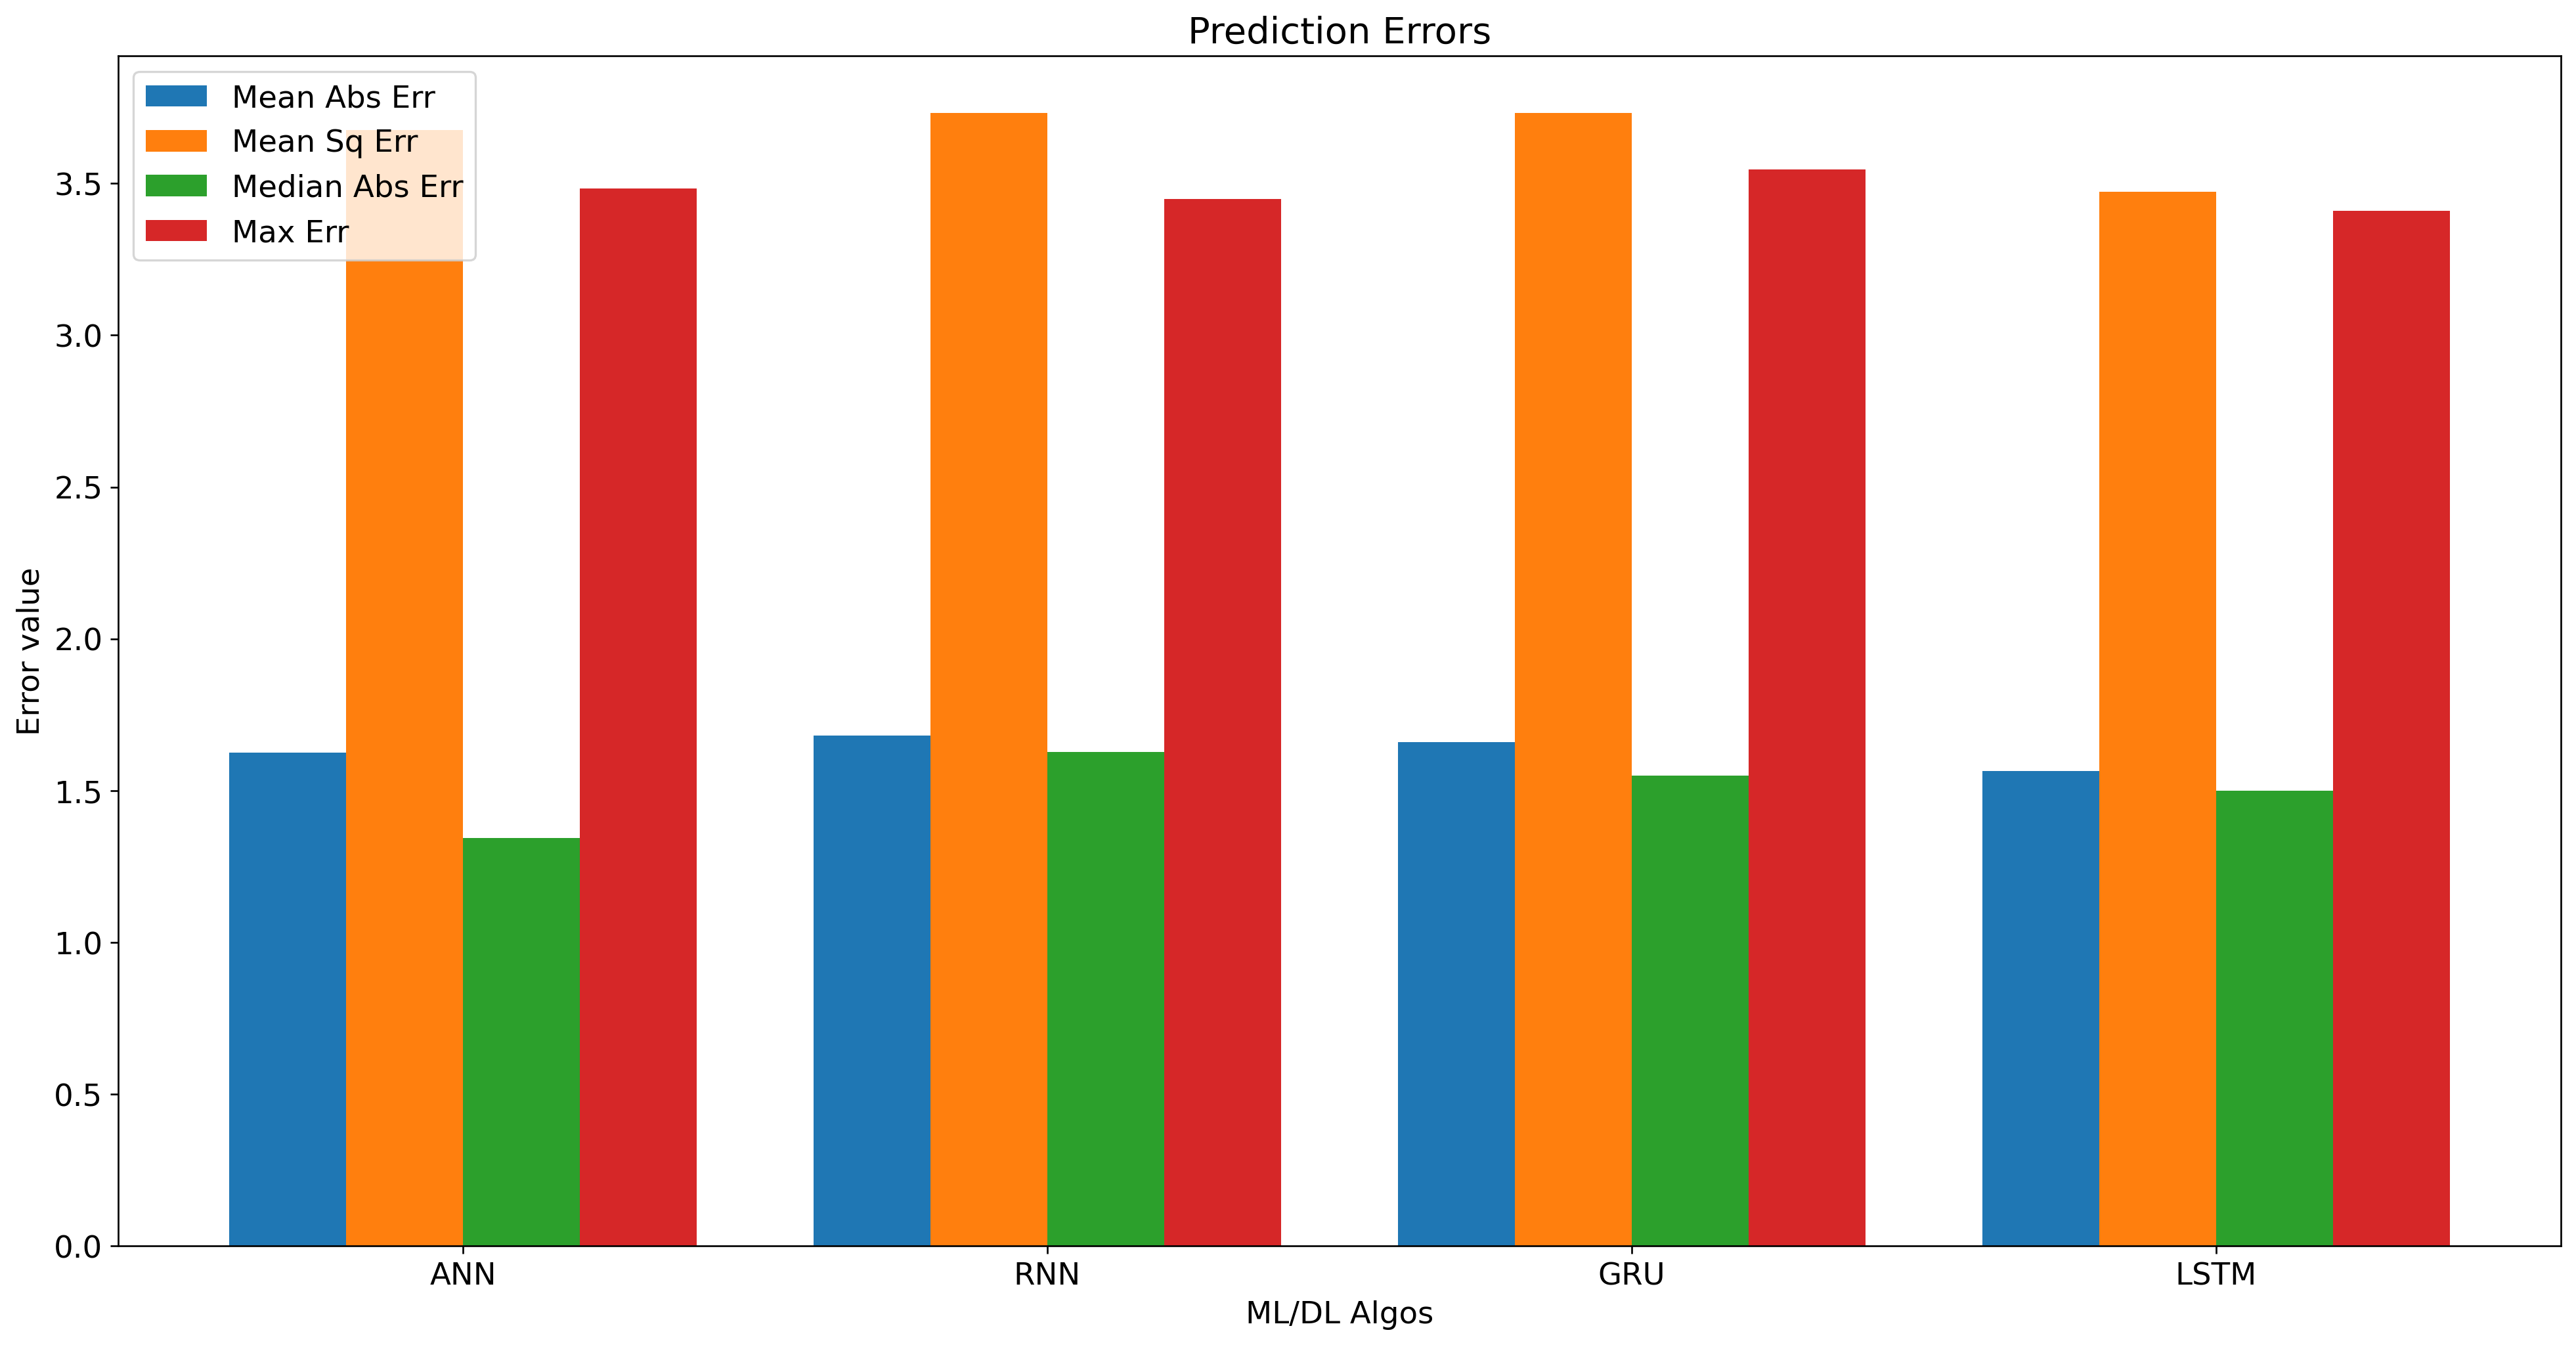

In [ ]:
print_comparison_graph(algos_name, error_names, error_val)